In [1]:
from configparser import ConfigParser
import pandas as pd
import numpy as np
import sqlalchemy
import datetime
from sklearn.linear_model import LinearRegression,Lasso,Ridge,RidgeCV,LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from functools import reduce
import seaborn as sns

%matplotlib inline


In [2]:
file = 'C:/Users/User/Source/config/config.ini'
config = ConfigParser()
config.read(file)

['C:/Users/User/Source/config/config.ini']

In [3]:
class db_connection(object):
    """
    Class for basic database interactions that will be used when copying data to a postgres DB.

    """

    def __init__(self, db_name: str):
        self.db_name = db_name

        self.flavor, self.engine, self.conn, self.cursor = self.create_connection()

    def create_connection(self):
        db_name = self.db_name
        flavor = ''
        connstring = ''
        if db_name == 'main':
            flavor = 'postgres'
            connstring = config['main']['Database'] + '://' + \
                         config['main']['User'] + ':' + \
                         config['main']['Password'] + '@' + \
                         config['main']['Server'] + ':' + \
                         config['main']['Port'] + '/' + \
                         config['main']['dbname']

        # print(connstring)
        engine = sqlalchemy.create_engine(connstring)
        conn = engine.raw_connection()
        cursor = conn.cursor()

        return flavor, engine, conn, cursor


def db_connect(db_name):
    return db_connection(db_name)

In [4]:
main = db_connect('main')

First Step is to ETL the data into a local Host Postgres server.     

I used pandas to get the table definitions correct first and ultimately used sqlalchemy copy expert for performance

In [5]:
# payouts = pd.read_csv('./data/payouts.csv',parse_dates=['date'])

In [ ]:
# payouts[:50].to_sql(name='payouts'
#                     , con=main.engine
#                     , schema='mint'
#                     , if_exists='replace'
#                     , chunksize=1000
#                     , index=False
#                     )

In [ ]:
copy_sql = """
           COPY mint.payouts FROM stdin WITH CSV HEADER
           DELIMITER as ','
           """

with open('./data/payouts.csv', 'r') as f:
    main.cursor.copy_expert(sql=copy_sql, file=f)
    main.conn.commit()

In [ ]:
# countries = pd.read_csv('./data/countries.csv')

In [ ]:
# countries[:50].to_sql(name='countries'
#                       , con=main.engine
#                       , schema='mint'
#                       , if_exists='replace'
#                       , chunksize=1000
#                       , index=False
#                       )

In [ ]:
copy_sql = """
           COPY mint.countries FROM stdin WITH CSV HEADER
           DELIMITER as ','
           """

with open('./data/countries.csv', 'r') as f:
    main.cursor.copy_expert(sql=copy_sql, file=f)
    main.conn.commit()

In [ ]:
# industries = pd.read_csv('./data/industries.csv')

In [ ]:
# industries[:50].to_sql(name='industries'
#                        , con=main.engine
#                        , schema='mint'
#                        , if_exists='replace'
#                        , chunksize=1000
#                        , index=False
#                        )

In [ ]:
copy_sql = """
           COPY mint.industries FROM stdin WITH CSV HEADER
           DELIMITER as ','
           """

with open('./data/industries.csv', 'r') as f:
    main.cursor.copy_expert(sql=copy_sql, file=f)
    main.conn.commit()

Now with everything in postgres It's a little easier to write CTE queries to get the data in the shape I want for modeling.

I wanted Date,Country and dollars

Translated the amount by multiplying count which I'm assuming is quantity and dividing by 100 to get dollars

In [166]:
sql = '''
WITH base
AS (
    SELECT coalesce(c.country, 'missing_country') AS country
    ,p.DATE::DATE
        ,To_Char(p.DATE, 'day') AS dow
        ,To_Char(p.DATE, 'month') AS month
        ,(p.amount * p.count) / 100 AS total_amount
    FROM mint.payouts p
    LEFT JOIN mint.countries c ON p.recipient_id = c.merchant_id
    )
SELECT DATE
    ,country
    ,dow
    ,month
    ,sum(total_amount)::DECIMAL(18, 2) AS total_amount
FROM base
GROUP BY DATE
    ,country
    ,dow
    ,month
'''

In [167]:
data = pd.read_sql(sql=sql
                    , con=main.conn
                    , parse_dates=['date']
                    
                       )

In [168]:
#Not totally sure what these are

data = data[data.country != 'missing_country']
# data = data[data.country == 'US']




data.reset_index(inplace=True,drop=True)
data.index.name = 'Id'


print('You have price data from {} to {}'.format(data.date.min().strftime('%m/%d/%Y-%I%p'),data.date.max().strftime('%m/%d/%Y-%I%p')))


You have price data from 12/31/2017-12AM to 12/30/2018-12AM


Starting to realize its the United States....and everybody else.

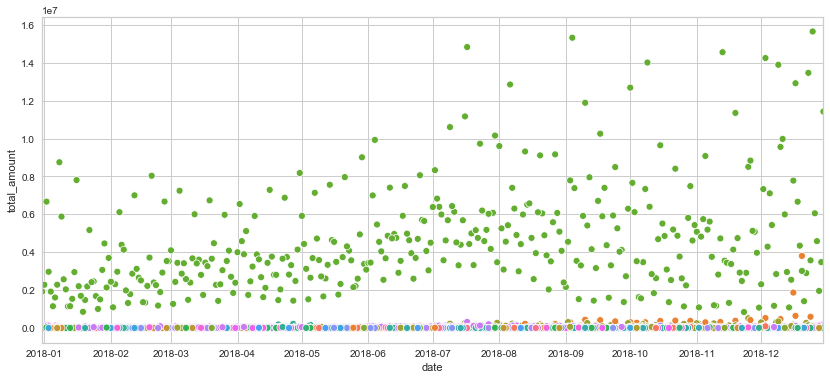

In [169]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[14, 6])
sns.scatterplot(x=data['date'], y='total_amount', data=data, ax=ax1, hue='country')
ax1.set_xlim(data.date.min(), data.date.max())
ax1.get_legend().remove()

plt.savefig('./Data/payout_scatter.png')

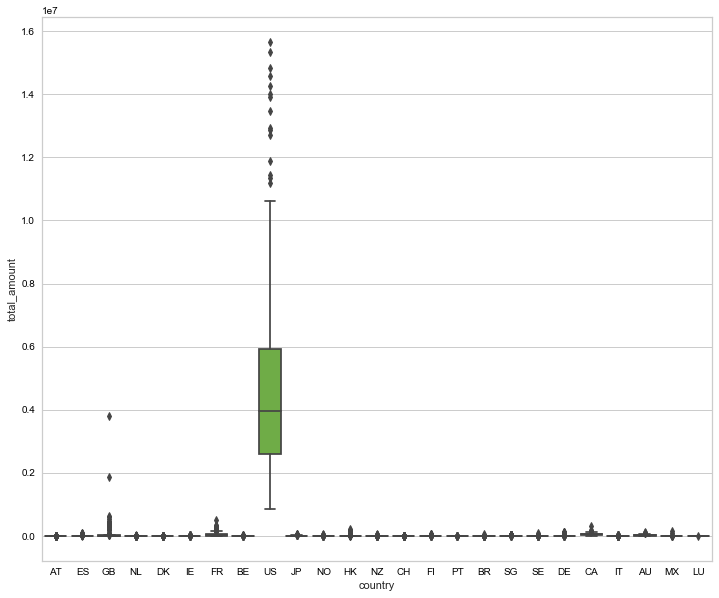

In [170]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black'}):
    fig, (ax1) = plt.subplots(nrows= 1, ncols =1 ,figsize=(12,10))
    sns.boxplot(x=data.country,y=data['total_amount'],data= data, ax=ax1)

    


plt.savefig('./Data/country_boxplot.png')    

In [171]:
# +02 is hundreds
# +03 is thousands
# +04 is tens of thousands
# +05 is hundreds of thousands
# +06 is millions
# +07 is tens of millions

data[data['country']=='US'].total_amount.describe().apply(lambda x: format(x, 'f'))

count         365.000000
mean      4596020.377452
std       2808802.304378
min        842522.680000
25%       2604545.840000
50%       3947248.990000
75%       5923875.390000
max      15659155.220000
Name: total_amount, dtype: object

In [172]:
data[data['country']!='US'].total_amount.describe().apply(lambda x: format(x, 'f'))

count       7386.000000
mean       13224.161962
std        58713.787867
min            0.480000
25%          780.542500
50%         2891.865000
75%         9635.725000
max      3804993.970000
Name: total_amount, dtype: object

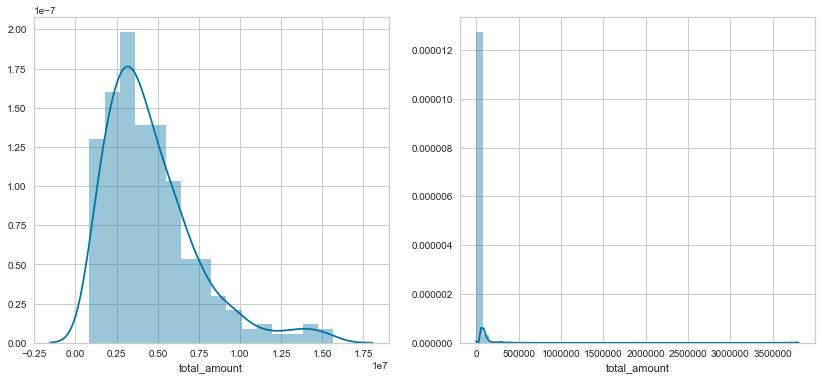

In [173]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize = [14,6])

sns.distplot(data[data['country']=='US'].total_amount,ax=ax1)
sns.distplot(data[data['country']!='US'].total_amount,ax=ax2)
plt.savefig('./Data/US_Hist.png') 

I'm going to use this predict DF to get answers from a fitted model

In [174]:
predict_sql='''
SELECT DISTINCT 
    '1/1/2019'::DATE AS DATE
    ,country AS country
    ,To_Char('1/1/2019'::DATE, 'day') AS dow
    ,To_Char('1/1/2019'::DATE, 'month') AS month
FROM mint.countries
'''

In [175]:
predict = pd.read_sql(sql=predict_sql
                    , con=main.conn
                    , parse_dates=['date']
                    
                       )
predict.index.name = 'Id'

Making dummy columns for my features and applying the same translations to my predict

In [176]:
data_t = pd.get_dummies(data=data, columns = ['dow','month','country'])
data_t = data_t.rename(columns=lambda x: x.strip())

In [177]:
predict_t = pd.get_dummies(data=predict, columns = ['dow','month','country'])
predict_t = predict_t.rename(columns=lambda x: x.strip())

In [178]:
#Make columns match for predict
missing_cols = set( data_t.columns ) - set( predict_t.columns )
for c in missing_cols:
    predict_t[c] = 0

In [179]:
features = [col for col in data_t.columns if col !='total_amount' and col !='date']

In [180]:
X = data_t[features]
X_predict = predict_t[features]


y = data_t['total_amount']

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=.9)


#something to compare performance. What if I just guess the mean?
y_baseline = [data.total_amount.mean()] * len(y_test)


print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(len(y_baseline))

(6975, 44)
(6975,)
(776, 44)
(776,)
776


In [182]:
model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_solution = model.predict(X_predict)







print("R-squared = ", metrics.r2_score(y_test,y_pred)) 
print("RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Baseline RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_baseline)))

R-squared =  0.7061043864392701
RMSE =  643194.1842746667
Baseline RMSE =  1187219.3459541542


Now with a fitted model and some evaluation metrics what do those actually mean.

A descently high R2 and a pretty serious improvement on Root Mean Square error compared to guessing the mean

But as I mentioned earlier it's the US and then everybody else. A linear model doesn't really seem to be fitting the data

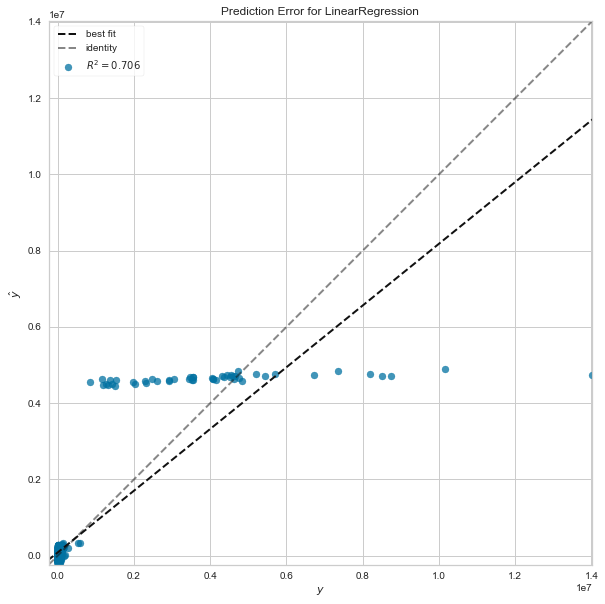

<Figure size 432x288 with 0 Axes>

In [183]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = [14,10])
visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data
plt.savefig('./Data/LinReg_PredictionError.png') 

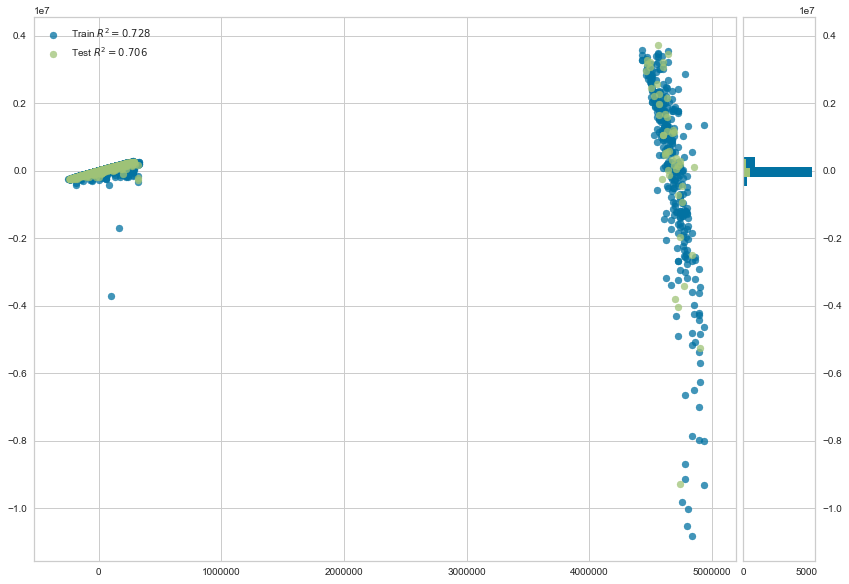

In [184]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = [14,10])

visualizer = ResidualsPlot(model,ax=ax)
visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data





plt.legend()
plt.savefig('./Data/LinReg_Residuals.png') 

Now I wanted to put the predictions back together with the data and see if it makes eyball sense

adding y_pred to the test data set

adding y_solution to my origin predict DF

In [185]:
#set index for predictions with x_test
y_pred= pd.DataFrame(y_pred,index=X_test.index)
y_pred.rename(columns={y_pred.columns[0]:'Predicted_Amount'}, inplace=True)


y_test= pd.DataFrame(y_test,index=X_test.index)
y_test.rename(columns={y_test.columns[0]:'Actual_Amount'}, inplace=True)

y_solution = pd.DataFrame(y_solution,index=predict.index)
y_solution.rename(columns={y_solution.columns[0]:'LinReg_Pred'}, inplace=True)



X_test.index.name = 'Id'
y_test.index.name = 'Id'

y_pred.index.name = 'Id'

In [186]:
dfs = (data,y_test,y_pred)
results = reduce(lambda left,right: pd.merge(left,right,on = 'Id'),dfs)


In [187]:
results.sort_values(by='Actual_Amount',ascending=True)[:75]

,date,country,dow,month,total_amount,Actual_Amount,Predicted_Amount
Id,,,,,,,
6918,2018-12-02,CH,sunday,december,6.33,6.33,98048.0
5476,2018-04-08,CH,sunday,april,10.00,10.00,-66048.0
6564,2018-09-01,FI,saturday,september,10.47,10.47,-38912.0
37,2018-06-04,SG,monday,june,10.82,10.82,205568.0
6802,2018-01-03,IE,wednesday,january,11.40,11.40,-109568.0
...,...,...,...,...,...,...,...
3476,2018-03-05,NL,monday,march,199.15,199.15,116992.0
2906,2018-04-21,SG,saturday,april,204.59,204.59,-146176.0
624,2017-12-31,NL,sunday,december,207.52,207.52,113408.0


In [188]:
dfs = (predict,y_solution)
answer = reduce(lambda left,right: pd.merge(left,right,on = 'Id'),dfs)
answer.drop(columns=['dow','month'],inplace=True)


### Question 1:
### Using the data provided, please provide an estimate for the amount of money we should expect to be paid out to each country  on Jan. 1, 2019 (the day after the last day in the dataset).

A prediction of 4.6 (5) Millon from the US and 0 from all the other countries is a prediction, but not confident that's the best we could do

Negative values make sense in terms of the linear model, but not so much in the actual world.



In [189]:
answer.sort_values(by='LinReg_Pred',ascending=False)

,date,country,LinReg_Pred
Id,,,
8,2019-01-01,US,4624896.0
11,2019-01-01,CA,17408.0
9,2019-01-01,FR,12288.0
12,2019-01-01,GB,9728.0
21,2019-01-01,AU,-13824.0
20,2019-01-01,ES,-29696.0
23,2019-01-01,JP,-30976.0
7,2019-01-01,SG,-31488.0
6,2019-01-01,DE,-34816.0


I wanted to do some moving averages as an eyeball test to put the 4.6 million from the linear regression into context

In [190]:
ma = data[['date','total_amount']]
ma = ma.set_index('date')
ma = ma.resample('D').sum()
ma['moving_average']=ma.rolling(window=28,center=False).mean()
total = ma.loc['12/30/2018'].moving_average
print('The latest 4 week moving average is: {}'.format(int(total)))

The latest 4 week moving average is: 7106806


In [191]:
ma.loc['12/1/2018':'12/30/2018']

,total_amount,moving_average
date,,
2018-12-01,2920584.32,5.029007e+06
2018-12-02,7938212.47,5.096843e+06
2018-12-03,15468400.37,5.295630e+06
2018-12-04,4586631.56,5.254200e+06
2018-12-05,7412860.13,5.306083e+06
2018-12-06,5727007.69,5.368211e+06
2018-12-07,1391164.13,5.361860e+06
2018-12-08,3366895.25,5.429956e+06
2018-12-09,14432180.46,5.835377e+06


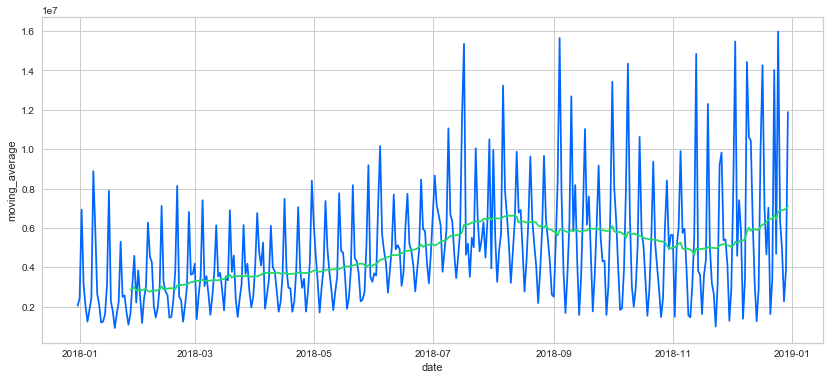

In [192]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = [14,6],)

sns.lineplot(x=ma.index, y = 'total_amount',color='#0066ff', data = ma,ax=ax  )
sns.lineplot(x=ma.index, y = 'moving_average',color='#1bdb65', data = ma,ax=ax  )
plt.savefig('./Data/AllCountry_MovingAverage.png') 

In order to come up with a best guess I decided to spread an amount across the non-US countries.

I took the latest Moving average from above

Subtracted the LinReg_Pred of the US

Divided it by the number of non us Contries

Added that to the LinReg_Pred

In [193]:
print('The most recent 4 week moving average is: {}'.format(int(total)))

total = int(total - answer[answer['country']=='US']['LinReg_Pred'])

print('Subtract the LinReg_Pred for the US: {}'.format(int(total)))

total = total/(len(answer)-1)

print('Divde that by the number of remaining countries: {}'.format(int(total)))
answer['Best_Guess']=0

The most recent 4 week moving average is: 7106806
Subtract the LinReg_Pred for the US: 2481910
Divde that by the number of remaining countries: 103412


In [194]:
for index, row in answer.iterrows():
    if row['country'] == 'US':
         answer.Best_Guess.iloc[index] = int(row['LinReg_Pred'])
    else:
        answer.Best_Guess.iloc[index] = int((total+row['LinReg_Pred']))
           


C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [195]:
answer.to_csv('./data/Q1_answers.csv')

In [196]:
answer

,date,country,LinReg_Pred,Best_Guess
Id,,,,
0,2019-01-01,IE,-38400.0,65012
1,2019-01-01,BR,-41728.0,61684
2,2019-01-01,SE,-35328.0,68084
3,2019-01-01,FI,-46592.0,56820
4,2019-01-01,IT,-43008.0,60404
5,2019-01-01,HK,-39680.0,63732
6,2019-01-01,DE,-34816.0,68596
7,2019-01-01,SG,-31488.0,71924
8,2019-01-01,US,4624896.0,4624896


Question 2:

Assume that one year from now, we will have 15 platforms from the Education industry, 5 from Hotels, Restaurants & Leisure and 40 from Food & Beverage. How much total payout volume do you expect to see on a typical day, from these three industries?


In [197]:
sql = '''
select 
i.industry
,count(distinct platform_id) as platforms
,count(p.platform_id) as transactions
,sum(amount/100)::DECIMAL(18, 2) as amount
from mint.payouts p
    right join mint.industries i
        on p.recipient_id = i.merchant_id

where i.industry in ('hotels, restaurants & leisure','Food & Beverage','Education')
group by i.industry

'''

In [198]:
platform = pd.read_sql(sql=sql
                    , con=main.conn
                    
                       )
platform

,industry,platforms,transactions,amount
0,Education,7,26055,3.524236e+07
1,Food & Beverage,17,148252,1.160524e+08
2,"hotels, restaurants & leisure",0,0,NaN


In [199]:
sql = '''
WITH base
AS (
    SELECT i.industry
        ,p.DATE::DATE
        ,(p.amount * p.count) / 100 AS total_amount
        ,p.platform_id
    FROM mint.payouts p
    JOIN mint.industries i ON p.recipient_id = i.merchant_id
    WHERE i.industry IN (
            'hotels, restaurants & leisure'
            ,'Food & Beverage'
            ,'Education'
            )
    )
SELECT DATE
    ,industry
    ,sum(total_amount)::DECIMAL(18, 2) AS total_amount
FROM base
GROUP BY DATE
    ,industry
'''

In [200]:
dfp=pd.read_sql(sql=sql
                , con=main.conn
                    
                       )

In [201]:
dfp[dfp['industry']=='Education'].total_amount.describe().apply(lambda x: format(x, 'f'))

count       359.000000
mean     117232.567326
std      128985.496644
min        -813.770000
25%        1120.950000
50%       90438.250000
75%      167176.300000
max      803630.720000
Name: total_amount, dtype: object

In [202]:
dfp[dfp['industry']=='Food & Beverage'].total_amount.describe().apply(lambda x: format(x, 'f'))

count        365.000000
mean      324025.805288
std       536737.685293
min      -163817.160000
25%        20041.220000
50%       137019.370000
75%       363001.410000
max      4025678.310000
Name: total_amount, dtype: object

In [203]:
grouped = dfp.groupby('industry', as_index=False).agg({"total_amount": ['mean','std']})
grouped.columns= ["_".join(x) for x in grouped.columns.ravel()]
grouped['Best_Guess']= grouped['total_amount_mean'] + grouped['total_amount_std']
grouped

,industry_,total_amount_mean,total_amount_std,Best_Guess
0,Education,117232.567326,128985.496644,246218.063970
1,Food & Beverage,324025.805288,536737.685293,860763.490581


In [204]:
grouped.to_csv('./data/Q2_answers.csv')